# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from CorInfoMaxBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99811966231251


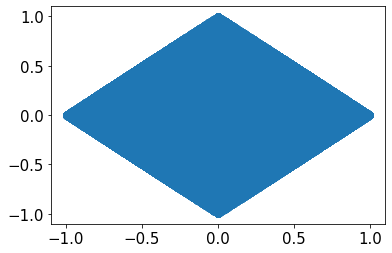

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = NumberofSources, size_sources = N, 
                                       decreasing_correlation = True)
S = 4 * S - 2
S = ProjectRowstoL1NormBall(S.T).T

# print("The following is the correlation matrix of sources")
# display_matrix(np.corrcoef(S))

plt.scatter(S[0,:], S[2,:])


# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

# Visualize Generated Sources and Mixtures

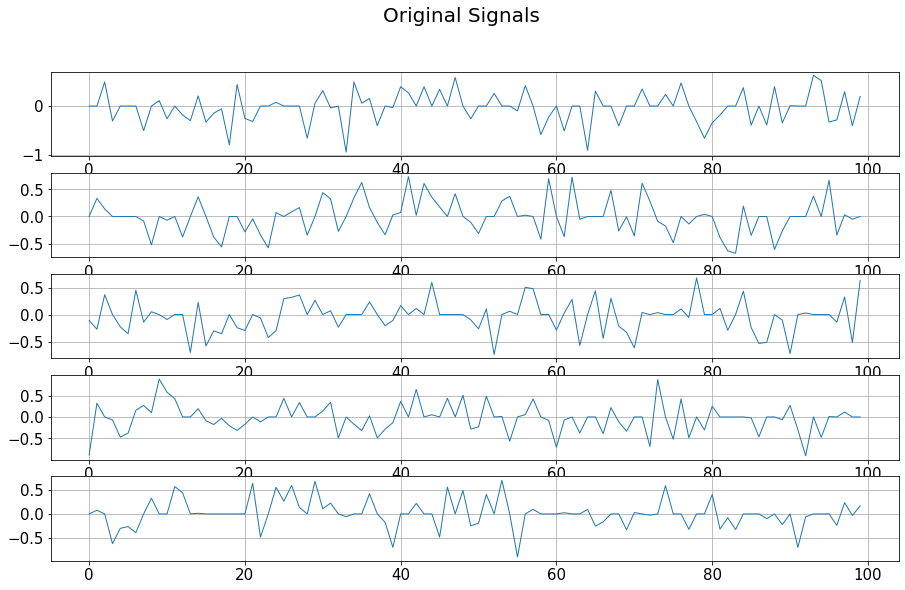

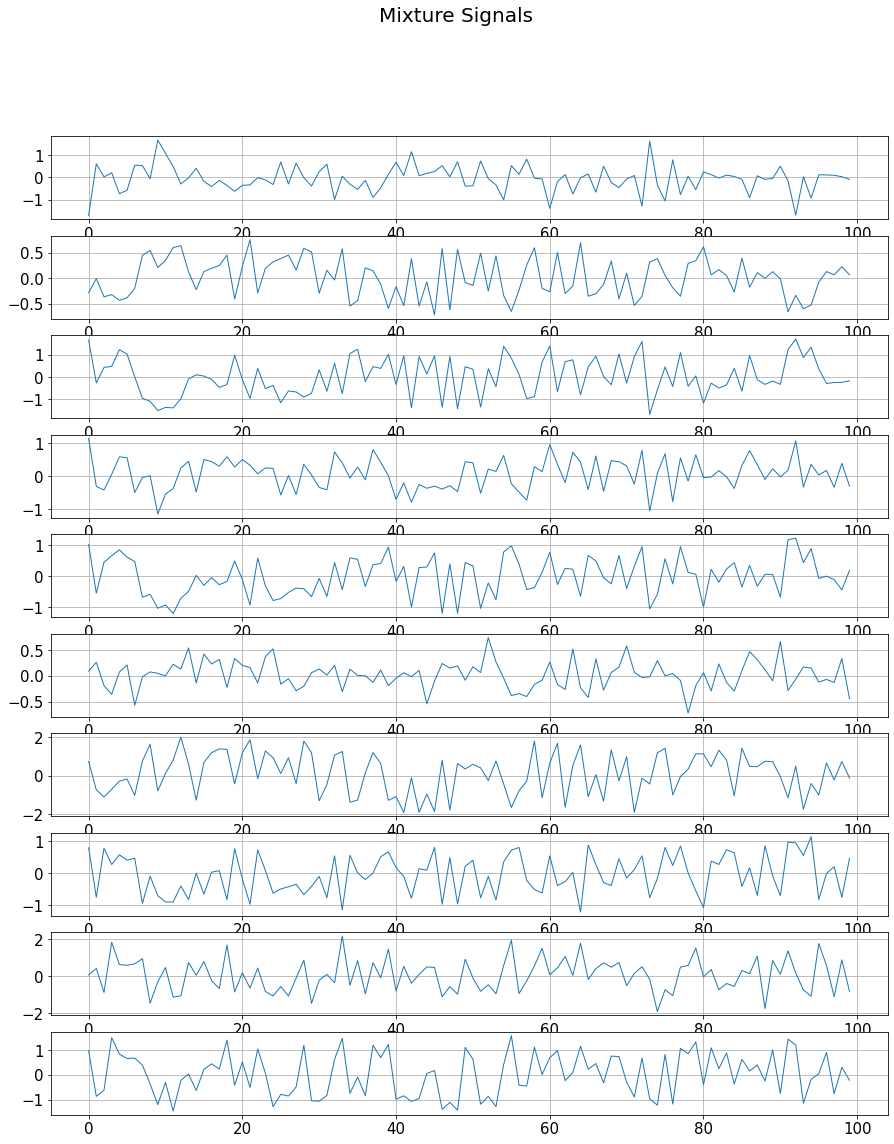

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-1/10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

debug_iteration_point = 10000
model = OnlineCorInfoMax(s_dim = s_dim, x_dim = x_dim, muW = 30*1e-3, lambday = lambday,
                         lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                         set_ground_truth = True, S = S, A = A)

# Run CorInfoMax Algorithm on Mixture Signals

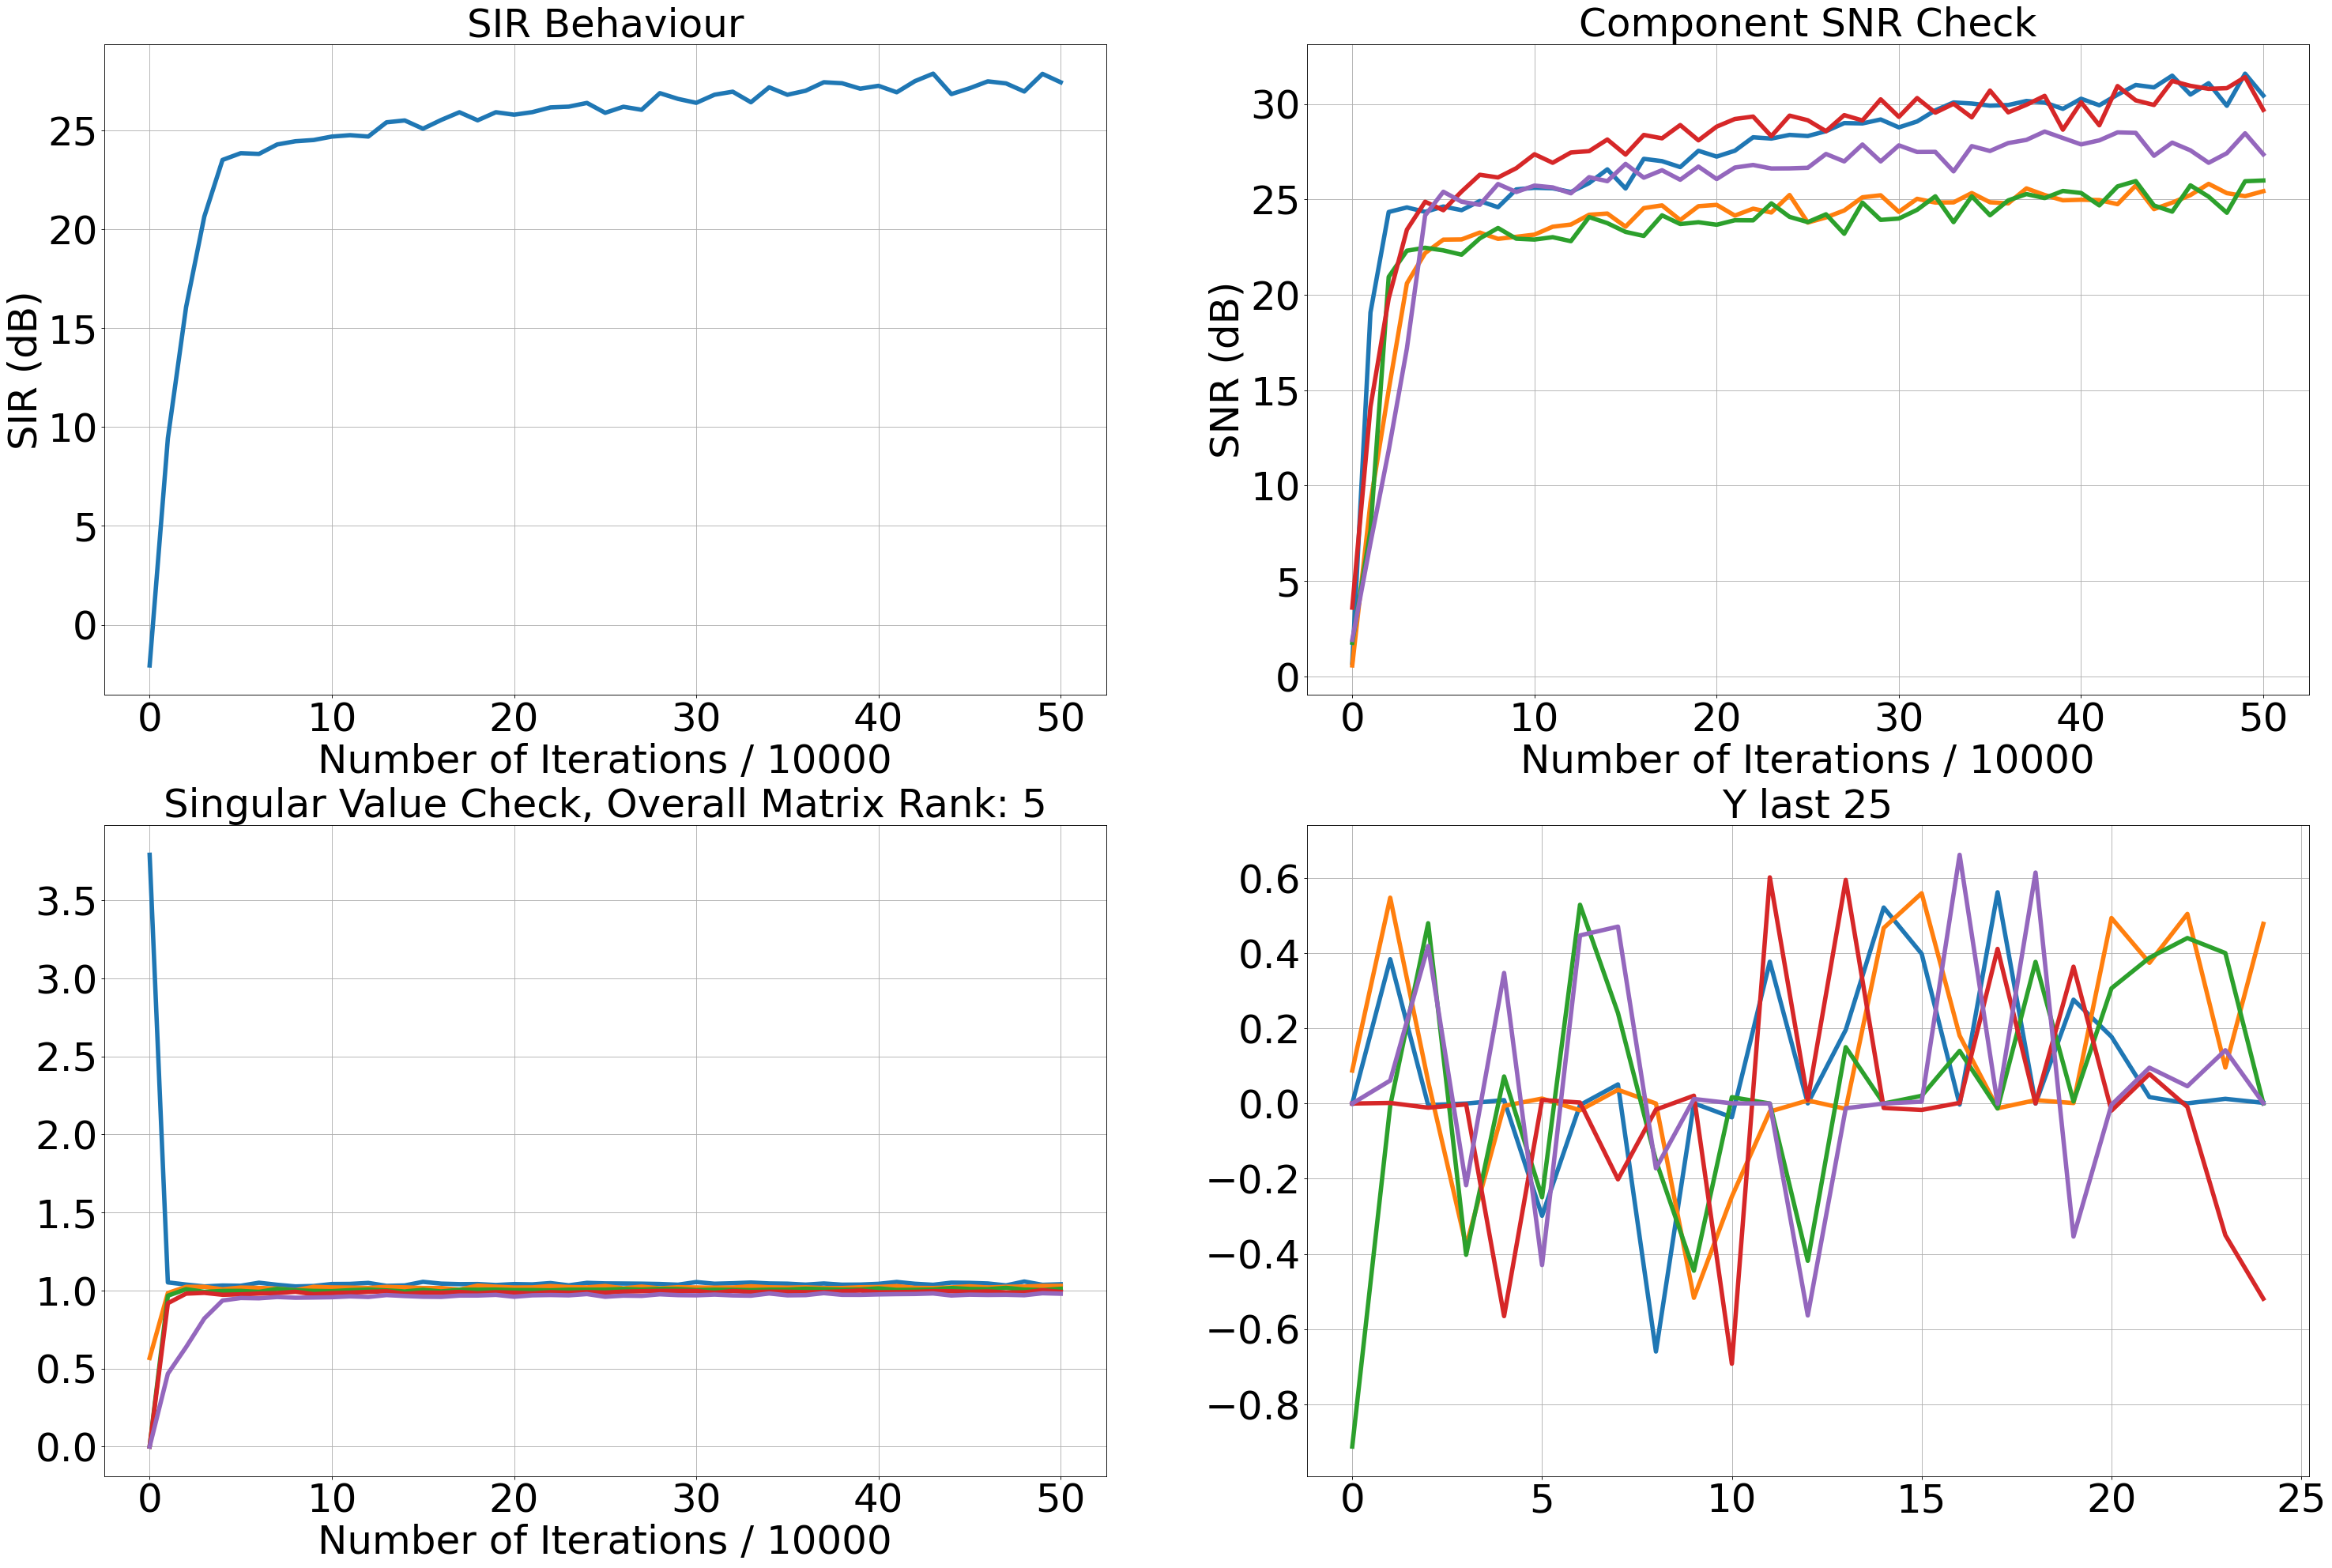

100%|██████████| 500000/500000 [11:28<00:00, 726.12it/s]


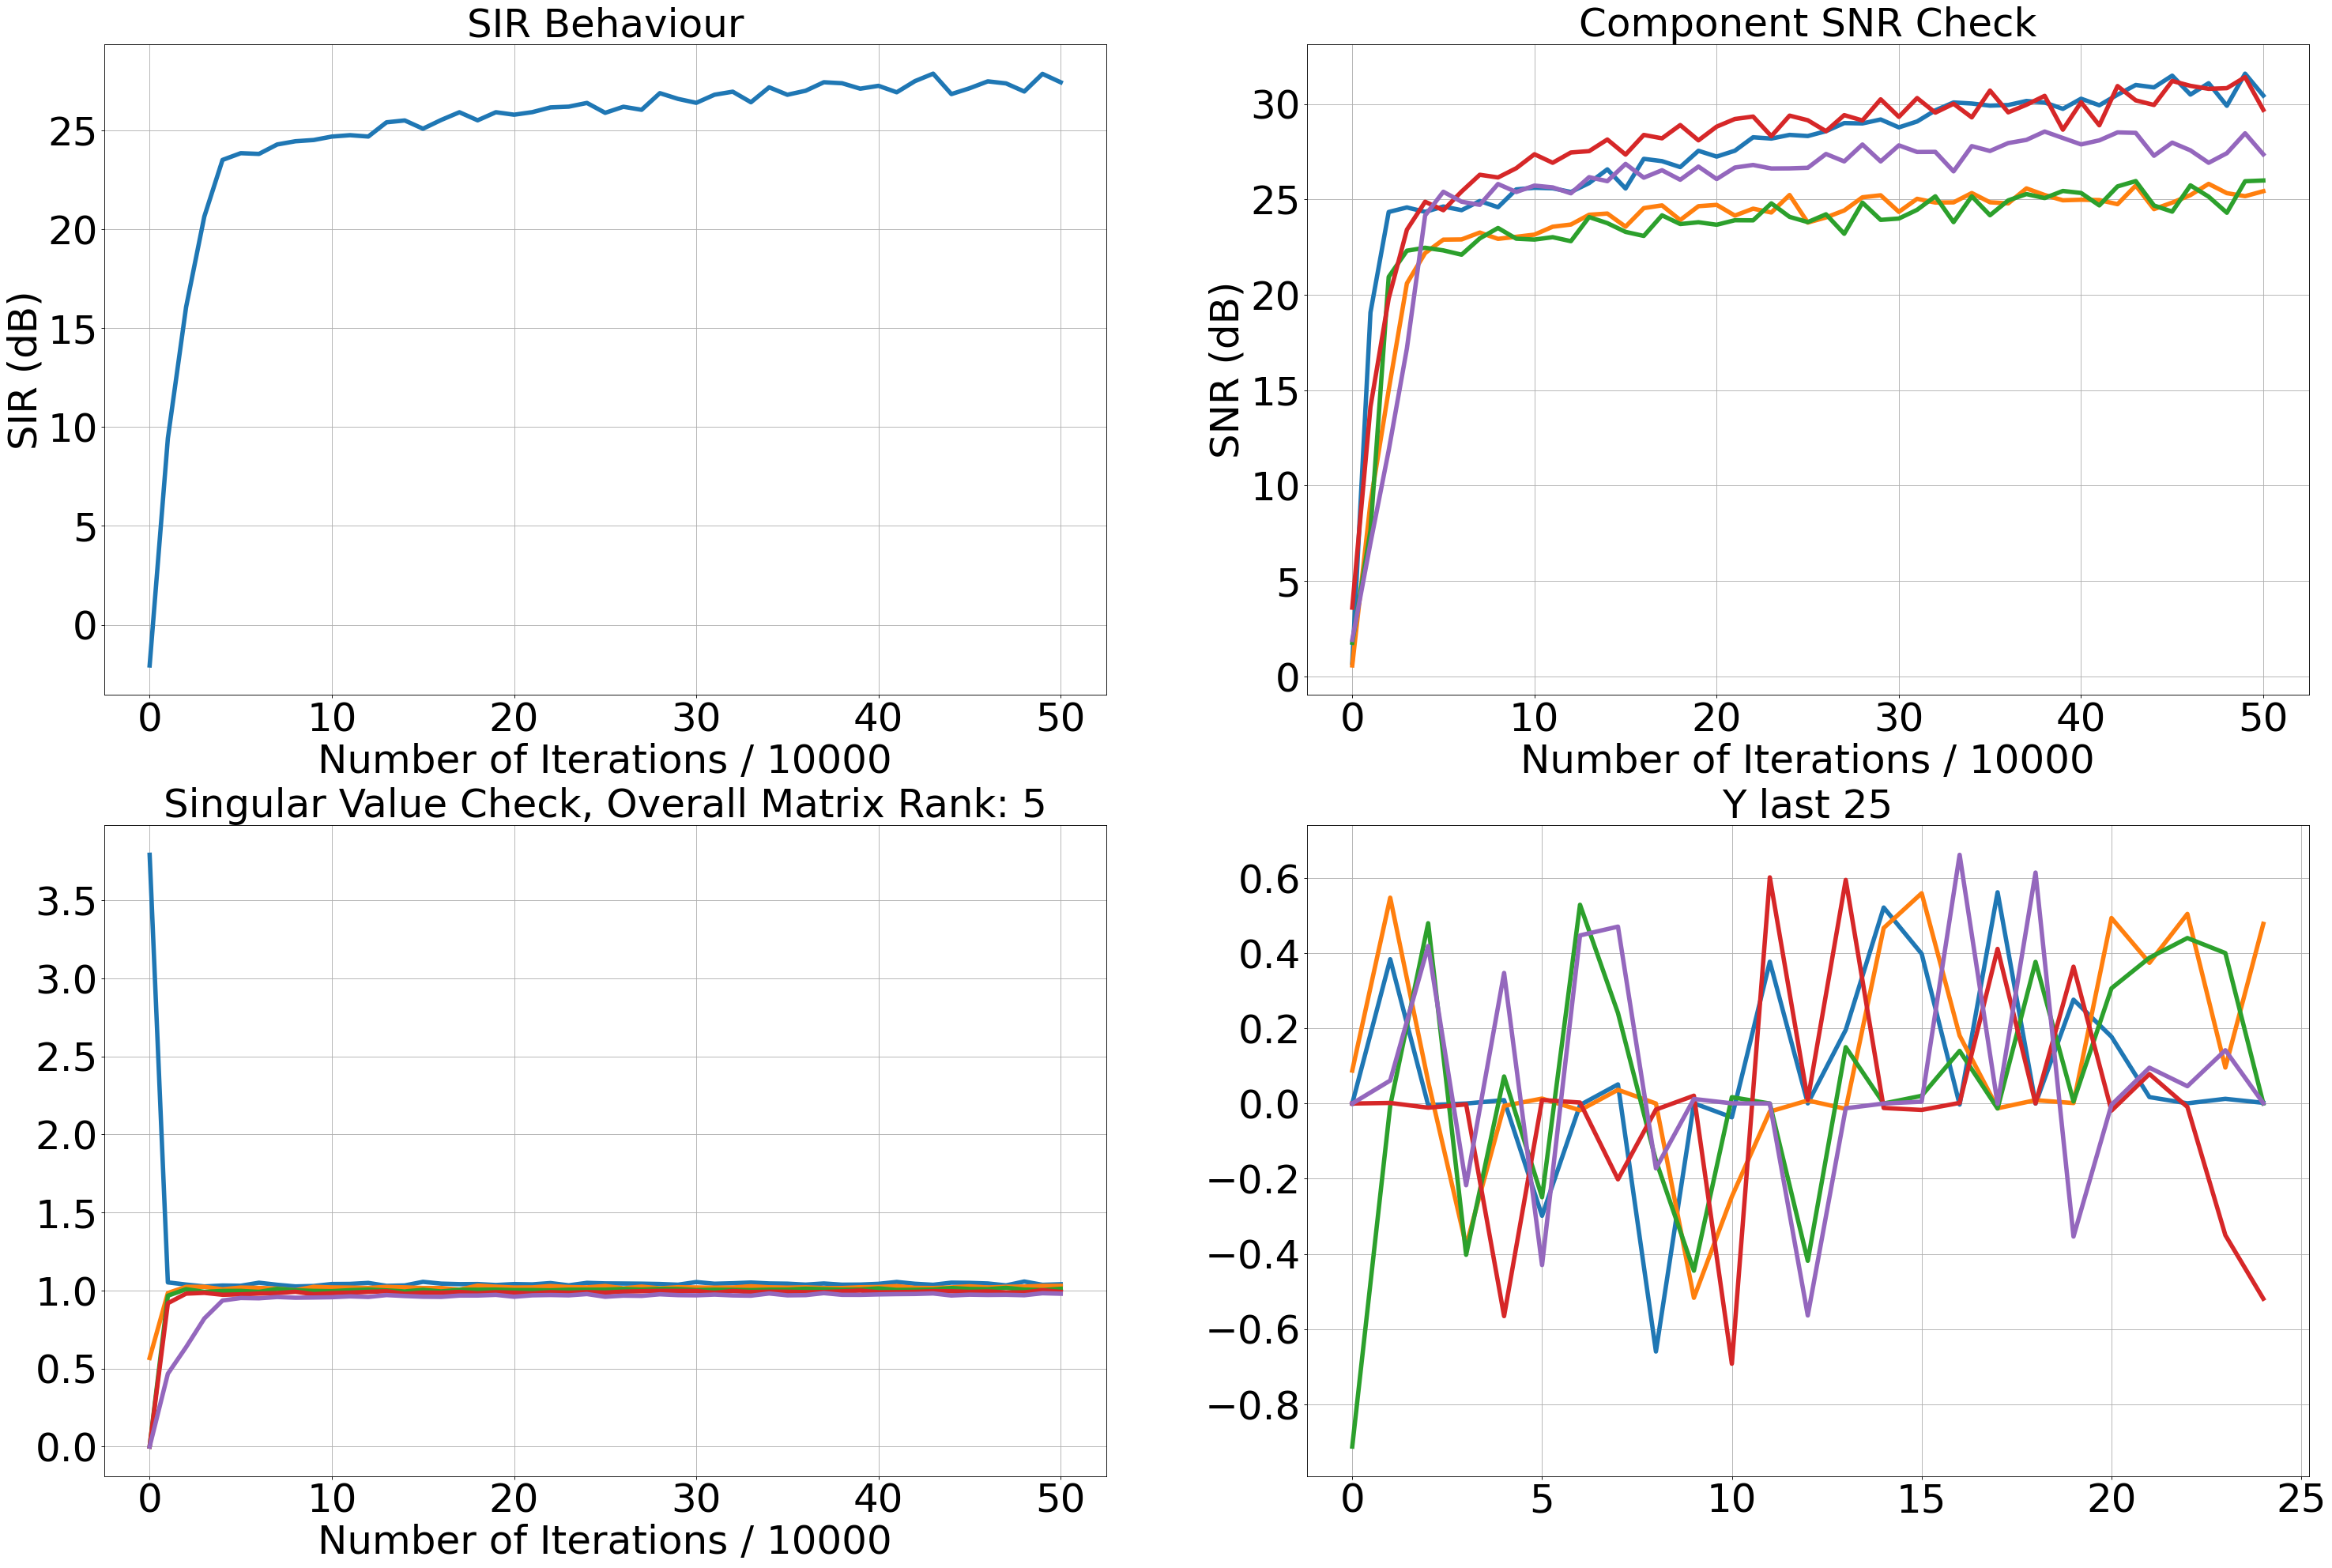

In [6]:
model.fit_batch_sparse(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                       plot_in_jupyter = True, neural_lr_start = 0.1,
                       neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                       shuffle = True)

# Visualize SINR Convergence 

Final SIR: 27.440084292503943


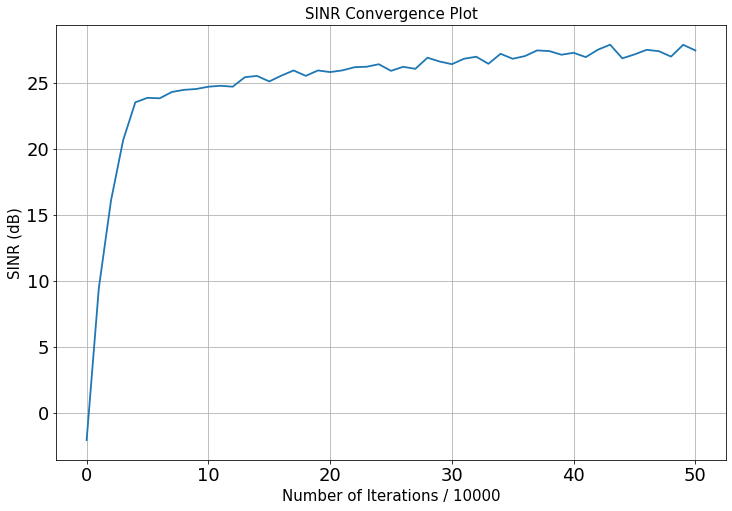

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SIR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SIR: {}'.format(np.array(model.SIR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [30.43861124 25.4267172  25.98852602 29.6896559  27.35838709]

Overall SINR : 27.440084292503943


# Vizualize Extracted Signals Compared to Original Sources

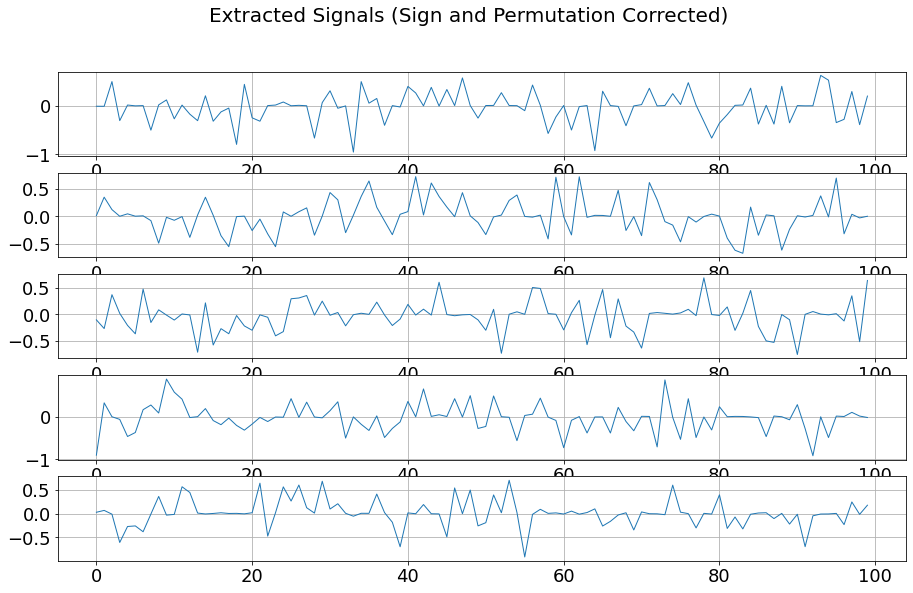

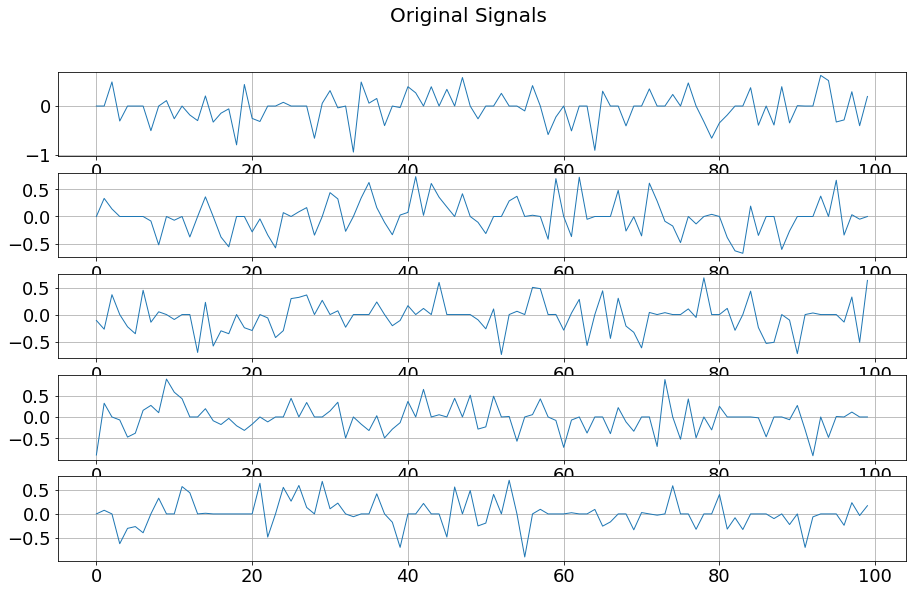

In [9]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)